In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt

import serial
import os
import pty
from IPython.display import clear_output
import time
import numpy as np

from pyquaternion import Quaternion

import serial

In [2]:
SERIAL_DEV = "/dev/serial/by-id/usb-Silicon_Labs_CP2102_USB_to_UART_Bridge_Controller_0001-if00-port0"
BAUDRATE = 115200

In [3]:
class SensorReader:
    def __init__(self, serial_dev, sensors_active=np.ones(6,)):
        self.serial_dev = serial_dev
        self.sensors_active = sensors_active
        self.serial = serial.Serial(self.serial_dev, baudrate=BAUDRATE)
        self.calibration_raw = None
        self.calibration_norm = None
        self.calibration = None
    
    def require_calibration(self):
        if self.calibration is None:
            raise Exception("Sensors are not calibrated! Call `calibrate()` first!")
        
    def raw_data_frame_iter(self):
        first_iteration = True
        stash = []
        self.serial.reset_input_buffer()
        self.serial.read_until(b"\n")

        while True:
            line = self.serial.read_until(b"\n")
            if line == b" \r\n":
                if first_iteration:
                    stash = []
                    first_iteration = False
                    continue
                yield stash
                stash = []
            else:
                stash.append(line)
                
    def parse_data_frame(self, frame):
        accelerations = []
        for i, line in enumerate(frame):
            if not self.sensors_active[i]:
                continue
            line = line.decode('ascii').rstrip('\r\n')
            acceleration = list(map(int, line.split(',')))
            accelerations.append(acceleration)

        return np.array(accelerations)
    
    def calibrate(self):
        self.calibration_raw = self.get_raw_acceleration()
        self.calibration_norm = np.linalg.norm(self.calibration_raw, axis=1)[:, np.newaxis]
        self.calibration = self.calibration_raw / self.calibration_norm
        
    def get_raw_acceleration(self):
        while True:
            try:
                return np.array(self.parse_data_frame(next(iter(self.raw_data_frame_iter()))))
            except ValueError:
                pass
            

    def get_acceleration(self):
        self.require_calibration()
        return self.get_raw_acceleration() / self.calibration_norm
    
    def get_angles(self, acceleration=None):
        if acceleration is None:
            acceleration = self.get_acceleration()
        radians = []
        for cali, accel in zip(self.calibration, acceleration):
            radians.append(radians_vectors(cali, accel))
        return np.array(radians)
    
    def print_raw_data(self):
        for frame in self.raw_data_frame_iter():
            print(self.parse_data_frame(frame))
            #time.sleep(0.1)
            clear_output(True)
            
    def get_rotation_axis(self, acceleration=None):
        if acceleration is None:
            acceleration = self.get_acceleration()
        axis = []
        for cali, accel in zip(self.calibration, acceleration):
            axis.append(rotation_axis(cali, accel))
        return np.array(axis)
    def get_quaternion(self, acceleration=None):
        if acceleration is None:
            acceleration = self.get_acceleration()
        quaternions = []
        for cali, acc in zip(self.calibration, acceleration):
            quaternions.append(quaternion(cali, acc))
        return quaternions
    
def cos_vectors(a, b):
    a_norm = np.linalg.norm(a)
    b_norm = np.linalg.norm(b)
    return np.dot(a, b) / (a_norm * b_norm)

def radians_vectors(a, b):
    r = np.arccos(cos_vectors(a, b))
    if np.isnan(r):
        r = 0
    return r

def rotation_axis(a, b):
    axis = np.cross(a, b)
    if np.linalg.norm(axis) <= 1e-6:
        axis = np.array([1, 0, 0])
    return axis / np.linalg.norm(axis)

def quaternion(a, b):
    return Quaternion(axis=rotation_axis(a, b), radians=radians_vectors(a, b))

In [4]:
s = SensorReader(SERIAL_DEV, sensors_active=[1, 1, 1, 1, 1, 1])

In [5]:
next(iter(s.raw_data_frame_iter()))

[b'-15, -4, 28 \r\n',
 b'-16, -3, 34 \r\n',
 b'-17, -1, 27 \r\n',
 b'-16, -4, 33 \r\n',
 b'-33, 0, 2 \r\n',
 b'-32, -1, 2 \r\n']

In [6]:
s.calibrate()

In [7]:
s.calibration

array([[-0.46852129, -0.12493901,  0.87457307],
       [-0.40233134, -0.08046627,  0.91195103],
       [-0.5095438 , -0.03184649,  0.85985517],
       [-0.4337015 , -0.10842537,  0.89450934],
       [-0.9981685 ,  0.        ,  0.06049506],
       [-0.9975675 , -0.03117398,  0.06234797]])

In [8]:
s.calibration_norm

array([[32.01562119],
       [37.28270376],
       [31.40063694],
       [36.89173349],
       [33.06055051],
       [32.07802986]])

In [9]:
s.get_acceleration()

array([[-0.46852129, -0.12493901,  0.90580782],
       [-0.40233134, -0.08046627,  0.91195103],
       [-0.5095438 , -0.03184649,  0.85985517],
       [-0.4337015 , -0.10842537,  0.89450934],
       [-0.9981685 ,  0.        ,  0.06049506],
       [-0.9975675 , -0.03117398,  0.06234797]])

In [10]:
s.get_rotation_axis()

array([[ 1.        ,  0.        ,  0.        ],
       [ 0.        , -0.99612985, -0.08789381],
       [ 0.        , -0.99931483, -0.03701166],
       [ 1.        ,  0.        ,  0.        ],
       [ 1.        ,  0.        ,  0.        ],
       [ 1.        ,  0.        ,  0.        ]])

In [11]:
q = s.get_quaternion()[0]
q.yaw_pitch_roll

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:95: RuntimeWarning: invalid value encountered in arccos


(2.7054392252357987e-05, 0.014243948072411052, -0.0037986521940187317)

In [12]:
for i in range(30):
    accel = s.get_acceleration()
    print(
        ' radians:',  s.get_angles(accel), '\n\n',
        'axis:\n', s.get_rotation_axis(accel), '\n\n',
        'acceleration:\n', accel,
    )
    clear_output(True)

 radians: [0.01474174 0.02428853 0.         0.         0.         0.        ] 

 axis:
 [[-0.25766265  0.96623494  0.        ]
 [ 0.         -0.99612985 -0.08789381]
 [ 1.          0.          0.        ]
 [ 1.          0.          0.        ]
 [ 1.          0.          0.        ]
 [ 1.          0.          0.        ]] 

 acceleration:
 [[-0.46852129 -0.12493901  0.90580782]
 [-0.42915342 -0.08046627  0.91195103]
 [-0.5095438  -0.03184649  0.85985517]
 [-0.4337015  -0.10842537  0.89450934]
 [-0.9981685   0.          0.06049506]
 [-0.9975675  -0.03117398  0.06234797]]


In [13]:
DEFAULT_LAYOUT = np.array([[3, 1], [4, 2], [6, 5]])

class PlotAngles:
    def __init__(self, sensor_ids=DEFAULT_LAYOUT, history_shown=250, figsize=None):
        self.history_shown = history_shown
        self.sensor_ids = sensor_ids
        
        n_sensors = self.sensor_ids.size
        rows, cols = self.sensor_ids.shape
        
        if figsize is None:
            figsize = (4*cols, 2*rows)
        self.fig, self.axes = plt.subplots(rows, cols, figsize=figsize)
        # self.fig.sup
        self.lines = {}
        
        self.data_buf = np.zeros((self.history_shown, n_sensors, 3))
        # data_buf = np.zeros((self.history_shown, self.n_sensors, 3))
        for sid, ax in zip(self.sensor_ids.flat, self.axes.flat):
            ax.set_title(sid)
            self.lines[sid] = []
            for i in range(3):
                x = np.arange(self.history_shown)
                self.lines[sid].append(ax.plot(x, np.zeros_like(x), label=['x', 'y', 'z'][i])[0])
            ax.set_ylim([-2.5, 2.5])
            ax.set_yticks([-2, 1, 0, -1, 2])
            ax.set_xticks([])
            ax.legend(loc='upper left', ncol=3, fontsize='x-small', numpoints=2)
            
    def update(self, acc):
        self.data_buf[:-1] = self.data_buf[1:]
        self.data_buf[-1] = acc
        for sid, ax in zip(self.sensor_ids.flat, self.axes.flat):
            for i, line in enumerate(self.lines[sid]):
                line.set_ydata(self.data_buf[:, sid-1, i])        
        
    def continouos_plot(self, sensor_reader, iterations=1000):
        for i in range(iterations):
            acc = sensor_reader.get_acceleration()
            self.update(acc)
            self.fig.canvas.draw()
            self.fig.canvas.flush_events()
            #time.sleep(0.01)

<IPython.core.display.Javascript object>


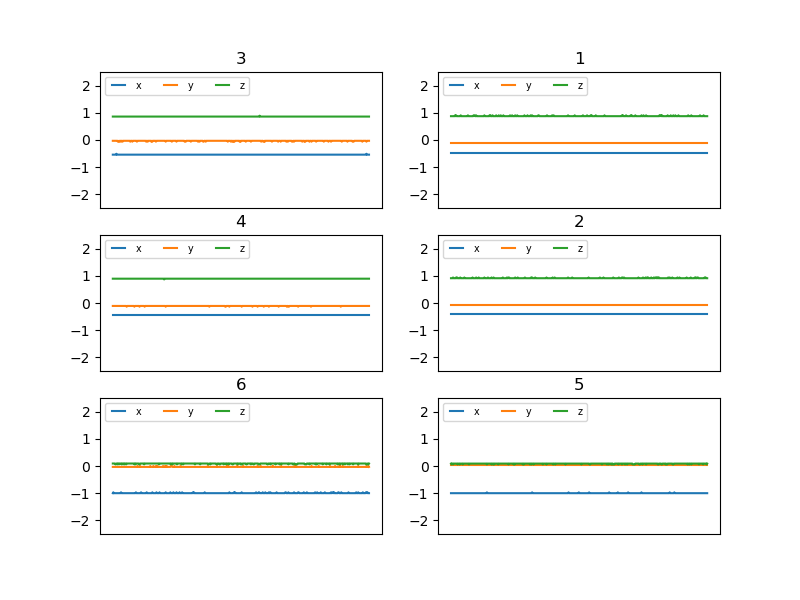

SerialException: read failed: device reports readiness to read but returned no data (device disconnected or multiple access on port?)

In [14]:
plot_angles = PlotAngles(history_shown=500)
plot_angles.continouos_plot(s, iterations=1000000)

In [21]:
s.get_rotation_axis()

array([[1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [0.83205029, 0.        , 0.5547002 ],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ]])

In [24]:
s.calibrate()

<IPython.core.display.Javascript object>


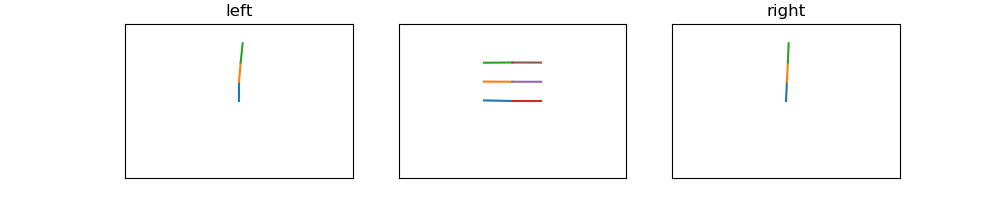

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:95: RuntimeWarning: invalid value encountered in arccos


KeyboardInterrupt: 

In [29]:
class PlotOrientation:
    def __init__(self, sensor_left=[6, 4, 3], sensor_right=[5, 2, 1]):
        self.fig, self.axes = plt.subplots(1, 3, figsize=(10, 2))
        self.sensor_left = sensor_left
        self.sensor_right = sensor_right
        self.ax_yl = self.axes[0]
        self.ax_yl.set_title("left")
        self.ax_z = self.axes[1]
        self.ax_yr = self.axes[2]
        self.ax_yr.set_title("right")
        
        for ax in self.axes.flat:
            ax.set_xlim([-4, 4])
            ax.set_ylim([-4, 4])
            ax.set_xticks([])
            ax.set_yticks([])
        self.lines = {}

        for sensor_idx in self.sensor_left:
            self.lines[('y', sensor_idx)] = self.ax_yl.plot([0], [0])[0]
            self.lines[('z', sensor_idx)] = self.ax_z.plot([0], [0])[0]
            
        for sensor_idx in self.sensor_right:
            self.lines[('y', sensor_idx)] = self.ax_yr.plot([0, 1], [0, 0])[0]
            self.lines[('z', sensor_idx)] = self.ax_z.plot([0, 1], [0, 0])[0]
            
    def plot_y(self, ax, sensor_ids, rot, axis):
        ends = [np.array([0, 0])]
        for sensor_id in sensor_ids:
            line = self.lines['y', sensor_id]
            idx = sensor_id - 1
            y = np.cos(rot[idx]*axis[idx, 1])
            x = np.sin(rot[idx]*axis[idx, 1])
            line_end = ends[-1] + np.array([x, y])
            line.set_xdata([ends[-1][0], line_end[0]])    
            line.set_ydata([ends[-1][1], line_end[1]])
            ends.append(line_end)
            
    def plot_z(self, ax, rot, axis):
        center = np.array([0, 0])
        for i, (sensor_l, sensor_r) in enumerate(zip(self.sensor_left, self.sensor_right)):
            linel = self.lines['z', sensor_l]
            liner = self.lines['z', sensor_r]
            sl = sensor_l - 1
            sr = sensor_r - 1
            
            y = np.cos(-rot[sl]*axis[sl, 2] + np.pi)
            x = np.sin(-rot[sl]*axis[sl, 2] + np.pi)
            
            linel.set_xdata([y + center[0], center[0]])
            linel.set_ydata([x + center[1], center[1]])
            
            y = np.cos(-rot[sr]*axis[sr, 2])
            x = np.sin(-rot[sr]*axis[sr, 2])
            
            liner.set_xdata([center[0], y + center[0]])
            liner.set_ydata([center[1], x + center[1]])
            center += np.array([0, 1])
            
    def update_plot(self, acc):
        rot = s.get_angles(acc)
        axis = s.get_rotation_axis(acc)
        self.plot_y(self.ax_yl, self.sensor_left, rot, axis)
        self.plot_z(self.ax_z, rot, axis)
        self.plot_y(self.ax_yr, self.sensor_right, rot, axis)

    def continouos_plot(self, sensor_reader, iterations=1000):
        for i in range(iterations):
            acc = sensor_reader.get_acceleration()
            self.update_plot(acc)
            self.fig.canvas.draw()
            self.fig.canvas.flush_events()
            time.sleep(0.01)
po = PlotOrientation()
po.continouos_plot(s, 320)